# 07 Reproducibility and Environment

This notebook ensures that the behavioural anomaly detection workflow developed in this exemplar is reproducible, robust, and shareable. Reproducibility is essential in scientific computing, particularly in high-stakes contexts such as behavioural monitoring, fraud detection, or security, where variation in model outputs due to environment changes could undermine trust.

In this notebook, we use a synthetic dataset to illustrate how reproducibility can be enforced through seed control, stable libraries, and output verification. The principles are transferable, but for full reproducibility using the clinical data, one would re-run the earlier pipeline using `InternalBleeding14.csv` under logged conditions.



### **Step 1 - Notebook Setup**

We begin by importing the core libraries already used throughout the exemplar. These support data visualisation, anomaly scoring, and clustering tasks. Ensuring reproducibility begins with documenting the exact computational environment, including version numbers for Python and all key packages.

Rather than relying on built-in attributes (which may be missing), the version of `hdbscan` is extracted using the `importlib.metadata` module. This approach is compatible with Python 3.8 and above, and is the recommended method for packages that do not expose a `__version__` attribute.

For clarity and professional practice, all code comments about technical adjustments are instead explained in this markdown cell. We have also imported the `warnings` module to suppress `FutureWarning` messages from `scikit-learn`, which might otherwise distract from the reproducibility focus of this notebook.

Learners may optionally run !pip list | tee environment_list.txt to export a full list of dependencies for future replication or publication.

In [ ]:
import sys
import platform
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import hdbscan
import matplotlib.pyplot as plt
import importlib.metadata
import warnings

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("scikit-learn version:", sklearn.__version__)

try:
    hdbscan_version = importlib.metadata.version("hdbscan")
    print("hdbscan version:", hdbscan_version)
except importlib.metadata.PackageNotFoundError:
    print("hdbscan version: not found")
except Exception as e:
    print("hdbscan version: error occurred –", str(e))


Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
numpy version: 2.0.2
pandas version: 2.2.2
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
hdbscan version: 0.8.40


---

### **Step 2 - Set Global Random Seed for Reproducibility**

To ensure consistent model behaviour across runs, we fix the random seed for both Python's built-in random module and NumPy. This practice stabilises random processes such as subsampling or noise generation, which are critical to algorithms like Isolation Forest.

We also import several components used in subsequent sections. These include:
- `make_blobs` for generating a synthetic dataset
- `PCA` for dimensionality reduction
- `IsolationForest` for unsupervised anomaly scoring

By doing this early in the notebook, we ensure that learners experience consistent results and that any subsequent randomness is traceable to the fixed seed. Without this setup, the same notebook could produce slightly different outputs on each execution, which undermines reproducibility.


In [ ]:
import random

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs


---



### **Step 3 - Reproducibility in Action - Isolation Forest**


 **Applying Isolation Forest for Anomaly Scoring**

We now apply the Isolation Forest algorithm to our synthetic dataset in order to generate anomaly scores. This model operates by recursively partitioning the data using random splits and measuring how quickly a point is isolated. The shorter the path to isolation, the more anomalous a point is considered.

Isolation Forest is particularly well suited to behavioural anomaly detection, as it makes no assumptions about the data distribution. However, its stochastic nature makes it sensitive to randomness, which means reproducibility must be handled explicitly.


In [ ]:
X, _ = make_blobs(n_samples=200, centers=1, cluster_std=0.60, random_state=RANDOM_STATE)
X[:10] += np.random.normal(0, 3, size=X[:10].shape)  # Add anomalies manually

model_a = IsolationForest(random_state=RANDOM_STATE)
model_a.fit(X)
scores_a = model_a.decision_function(X)
labels_a = model_a.predict(X)

**Rerunning Isolation Forest with the Same Random Seed**

To demonstrate how seeding ensures reproducibility, we rerun the Isolation Forest model using the same random state. By fixing the seed, we aim to produce identical anomaly scores and predictions, thus verifying that our results can be repeated reliably.

This step mirrors good practice in computational science, where reproducibility is regarded as the minimum threshold for trust in model outputs (Peng, 2011).

In [ ]:
model_b = IsolationForest(random_state=RANDOM_STATE)
model_b.fit(X)
scores_b = model_b.decision_function(X)
labels_b = model_b.predict(X)

**Verifying Output Consistency**

Here, we compare the anomaly scores and prediction labels from both model runs. If seeding has been correctly implemented, both outputs should match exactly. This reinforces the concept that deterministic model behaviour is essential for scientific reproducibility and deployment in regulated environments.

Any inconsistency, even if minor, could raise doubts about the robustness of our modelling process. Ensuring reproducibility is not merely a technical detail but a scientific responsibility.


Scores equal: True
Labels equal: True


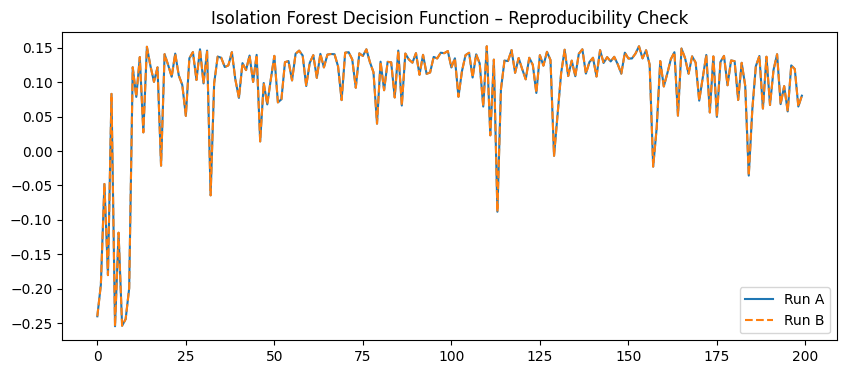

In [ ]:
print("Scores equal:", np.allclose(scores_a, scores_b))
print("Labels equal:", np.array_equal(labels_a, labels_b))

plt.figure(figsize=(10, 4))
plt.plot(scores_a, label='Run A')
plt.plot(scores_b, linestyle='dashed', label='Run B')
plt.title("Isolation Forest Decision Function – Reproducibility Check")
plt.legend()
plt.show()


The output confirms that both the anomaly scores and predicted labels are identical across runs (`True` for both tests), validating the effectiveness of the seeding procedure. This demonstrates that Isolation Forest, when provided a fixed `random_state`, produces entirely deterministic results.

Visually, the plot reveals perfect overlap between the two runs, with Run B (dashed line) tracing precisely over Run A. This reinforces the model’s reproducibility under controlled conditions and exemplifies good scientific practice, where identical code yields identical results.

Such reproducibility is essential not only for model trust but also for operational robustness when deploying unsupervised anomaly detection in behavioural or safety-critical environments.

---

### **Step 4 - Reproducibility HDBSCAN Clustering**


To make clustering outputs more interpretable, we reduce our data to two dimensions using Principal Component Analysis (PCA). PCA is a deterministic method, meaning that if no randomness is introduced, it will consistently produce the same transformed values for a given input.

Reducing to 2D enables us to visualise the output of the HDBSCAN clustering algorithm clearly. While the clustering itself is unsupervised, ensuring the input remains stable allows us to assess whether the algorithm behaves consistently across runs.

We also suppress `FutureWarning` messages during execution to maintain a clean output, particularly when using `scikit-learn` utilities that may change in future versions.

HDBSCAN labels identical: True


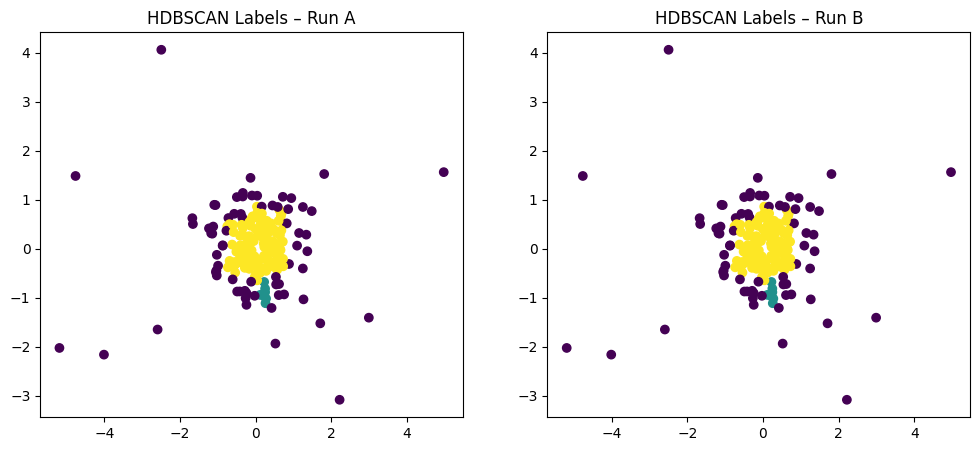

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

    clusterer_a = hdbscan.HDBSCAN(min_cluster_size=5)
    labels_hdb_a = clusterer_a.fit_predict(X_2d)

    clusterer_b = hdbscan.HDBSCAN(min_cluster_size=5)
    labels_hdb_b = clusterer_b.fit_predict(X_2d)

print("HDBSCAN labels identical:", np.array_equal(labels_hdb_a, labels_hdb_b))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_hdb_a, cmap='viridis')
axs[0].set_title("HDBSCAN Labels – Run A")
axs[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_hdb_b, cmap='viridis')
axs[1].set_title("HDBSCAN Labels – Run B")
plt.show()


The output confirms that the cluster labels produced by HDBSCAN are identical across both runs (`True`). This reflects the deterministic nature of the algorithm when applied to the same data, without randomness introduced through preprocessing.

Visually, the side-by-side scatter plots show identical cluster assignments. Each point retains its colour-coded cluster across both panels, and outliers remain consistently positioned. This visual stability supports the claim that HDBSCAN does not require explicit seeding, provided the input remains unchanged.

These results reinforce the importance of stable inputs when evaluating reproducibility in unsupervised clustering. In real-world behavioural systems, such consistency supports reliable grouping and downstream decision-making.


### **Step 5 - Export Reproducibility Files**

To ensure that others can recreate our environment exactly, it is good practice to export the full list of package dependencies. This step allows collaborators, reviewers, or future users to reproduce the computational setup down to the library version.

If we are using pip, we can generate a plain text file listing all installed packages:

In [ ]:
# !pip freeze > requirements.txt

Alternatively, if our workflow uses conda, we may prefer to export the full environment specification as a .yml file:

In [ ]:
# !conda env export > environment.yml

---

### **Reflection and Summary**

Reflection Questions for Learners:

1. Why is setting a random seed important in unsupervised anomaly detection?
2. If your model gives different anomaly scores on a colleague's machine, how would you debug it?
3. How might changing the version of `scikit-learn` or `numpy` affect reproducibility?
4. What steps can be taken to ensure a model behaves identically during deployment?
5. Why does HDBSCAN yield the same result even when rerun—what makes it deterministic?

Optional Task: Try rerunning HDBSCAN on data with slight perturbations. Observe how sensitive the clusters are.

In summary this notebook has demonstrated how to:
- Log your environment for reproducibility.
- Set seeds to stabilise randomness in models.
- Confirm output consistency across reruns.
- Export your environment for future re-use.
- Validate reproducibility in clustering with HDBSCAN.

These steps are crucial in scientific computing, enabling trust and repeatability—both within your team and by external reviewers.

---



### **Further Reading and References**

- Peng, R.D., 2011. *Reproducible research in computational science.* Science, 334(6060), pp.1226–1227.

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. and Duchesnay, E., 2011. Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, pp.2825–2830.  


- Grüning, B., Chilton, J., Köster, J., Dale, R., Soranzo, N., van den Beek, M., Goecks, J., Backofen, R., Nekrutenko, A. and Taylor, J., 2018. *Practical computational reproducibility in the life sciences*. Cell Systems, 6(6), pp.631–635.



